In [49]:
import numpy as np # type: ignore
import pandas as pd # type: ignore
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore
import os
from pathlib import Path
from datetime import datetime

In [50]:
def addTimeInformation(df):
    df['Time'] = df['Datum'].dt.time
    df['Month'] = df['Datum'].dt.strftime('%b')
    df['Year Month'] = df['Datum'].dt.strftime('%Y %m')
    df['Year Month Day'] = df['Datum'].dt.strftime('%Y %m %d')
    df['Day'] = df['Datum'].dt.strftime('%d')
    df['Year'] = df['Datum'].dt.strftime('%Y')
    df['Weekday'] = df['Datum'].dt.strftime('%u')
    df['Week'] = df['Datum'].dt.strftime('%W')
    return df

In [51]:
def read_SMARD_data(path):
    df = pd.read_csv(path,delimiter= ';', thousands='.', decimal=',', dayfirst ="True") #, parse_dates=[[0,1]]

    #Herauslöschen der Spalte Datum bis, da diese keine zusätzlichen Informationen bietet
    df.drop(columns=["Datum bis"], inplace=True)

    #Umbenennung der Spalten
    df.rename(columns={
        "Datum von":"Datum",
        "Biomasse [MWh] Originalauflösungen":"Biomasse",
        "Wasserkraft [MWh] Originalauflösungen":"Wasserkraft",
        "Wind Offshore [MWh] Originalauflösungen":"Wind Offshore",
        "Wind Onshore [MWh] Originalauflösungen":"Wind Onshore",
        "Photovoltaik [MWh] Originalauflösungen":"Photovoltaik",
        "Sonstige Erneuerbare [MWh] Originalauflösungen":"Sonstige Erneuerbare",
        "Kernenergie [MWh] Originalauflösungen":"Kernenergie",
        "Braunkohle [MWh] Originalauflösungen":"Braunkohle",
        "Steinkohle [MWh] Originalauflösungen":"Steinkohle",
        "Erdgas [MWh] Originalauflösungen":"Erdgas",
        "Pumpspeicher [MWh] Originalauflösungen":"Pumpspeicher",
        "Sonstige Konventionelle [MWh] Originalauflösungen":"Sonstige Konventionelle"    
    }, inplace = True)

    #Formatierung der Datumstpalte
    df['Datum'] = pd.to_datetime(df['Datum'], format= '%d.%m.%Y %H:%M')
    addTimeInformation(df)

    
    return df

Funktion, die eine CSV Datei einließt und einen dataFrame zurückgibt

In [52]:
def getData():
    dataFrames = {} # Dictionary für die df für jedes Jahr
    path_var = "C:\\Users\\aaron\\OneDrive - HAW-HH\\IPJ\\Team-Code\\Klimaneutral-20245\\CSV\\" #Pfad auf den Ordner, um später durch die Datein zu navigieren
    #project_root = Path(__file__).resolve().parent.parent
    #csv_folder = project_root/ "CSV"

    #Schleife für die Jahre 2015-2023 und Einlesen der Datei
    for year in range(2015,2024): # hier könnte man später sich die Jahre auch vom User geben lassen, welche Jahre er gerne eingelesen haben möchte
        #Dateipfad für das entsprechende Jahr
        file_path = os.path.join(path_var, f"Realisierte_Erzeugung_{year}01010000_{year+1}01010000_Viertelstunde.csv")
        if os.path.exists(file_path):   #Falls dieser zusammengesetze Pfad existiert,...
            dataFrames[year] = read_SMARD_data(file_path)   #... soll dieser eingelesen werden
            print(f"Data für {year} loaded succsessfully.")
        else:
            print(f"File for {year} not found at path: {file_path}") #... anstonsten nicht

    
    return dataFrames   #Rückgabe der eingelesenen Date als DataFrame
    


In [53]:
class Extrapolation: #Erstellt ein Objekt, welches ein DataFrame mitbekommt, und bestimmte werte aus diesen DataFrame Multipliziert
    def __init__ (self, df, factor, year):
        self.df = df
        self.factor = factor
        self.year = year

        self.multiply()
        self.update_year()
        addTimeInformation(self.df)

    def multiply(self):
        self.df["Photovoltaik"] = self.df["Photovoltaik"]*self.factor
        self.df["Wind Offshore"]= self.df["Wind Offshore"] * self.factor
        self.df["Wind Onshore"] = self.df["Wind Onshore"] * self.factor

    def update_year(self):
        # Ändern der Jahreskomponente in der "Datum"-Spalte
        self.df["Datum"] = self.df["Datum"].apply(lambda x: x.replace(year=self.year))

In [54]:
def combineDataFrames(directory, startYear, endYear): #Funktion, die alle DataFrames aus dem jährlichen Verzeichnis zusammenführt
    filterdDirectory = {year: df for year, df in directory.items() if startYear <= year <= endYear} #Zusammenführung der dataFrames aus dem Dictionary zwischen den angegebenen Jahren und Speicherung in ein vorläufiges df
    combined_df = pd.concat(filterdDirectory.values()) #zusammenführung der Daten der gewünschten Jahre
    combined_df['Datum'] = pd.to_datetime(combined_df['Datum'], format='%d.%m.%Y %H:%M') #Formatierung der Datum Spalte in DateTime
    addTimeInformation(combined_df)
    return combined_df


In [55]:
# Heatmap über Monate und Tage
def plotCalendarHeatmap(df, title, colName, linewidths=0.01):
    heatmap_data = df.pivot_table(index='Year Month', columns='Day', values=colName, aggfunc=np.sum)    # aggfunc=np.sum ->Werte summiert über den Tag!

    plt.figure(figsize=(20, 8))
    sns.heatmap(heatmap_data, cmap='coolwarm', annot=False, linewidths=linewidths, cbar=True, xticklabels=1)

    plt.title(title)
    plt.xlabel('Tag')
    plt.ylabel('Monat')

    plt.show()

Data für 2015 loaded succsessfully.
Data für 2016 loaded succsessfully.
Data für 2017 loaded succsessfully.
Data für 2018 loaded succsessfully.
Data für 2019 loaded succsessfully.
Data für 2020 loaded succsessfully.
Data für 2021 loaded succsessfully.
Data für 2022 loaded succsessfully.
Data für 2023 loaded succsessfully.


C:\Users\aaron\AppData\Local\Temp\ipykernel_7764\2309958722.py:3: FutureWarning: The provided callable <function sum at 0x0000020B3E0BDB20> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  heatmap_data = df.pivot_table(index='Year Month', columns='Day', values=colName, aggfunc=np.sum)    # aggfunc=np.sum ->Werte summiert über den Tag!


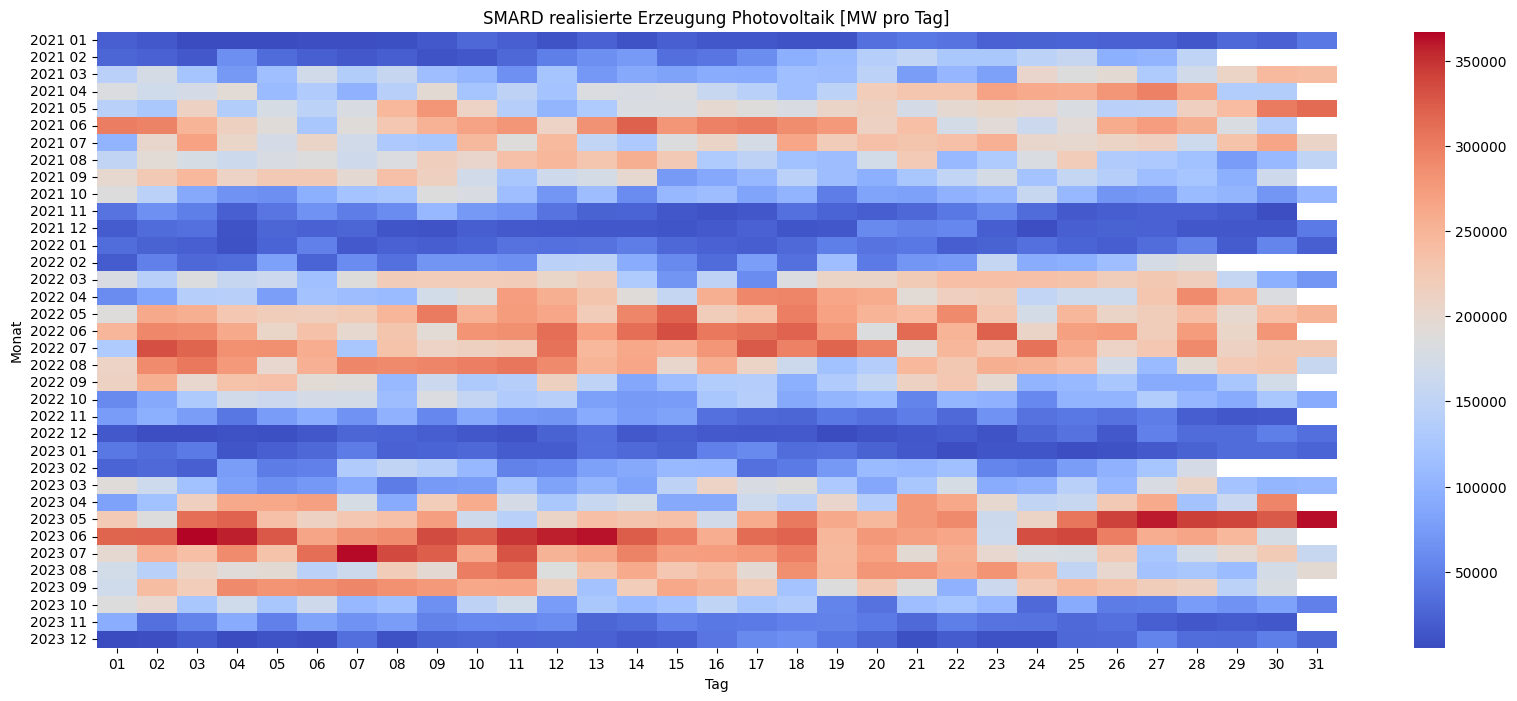

In [56]:
path_23_viertelStunde = "C:\\Users\\aaron\OneDrive - HAW-HH\\IPJ\\Team-Code\\Klimaneutral-20245\\Realisierte_Erzeugung_202301010000_202401010000_Viertelstunde (3).csv"

directory_yearly_generation=getData()

for year in range(2024,2031):
    prev_year_df =directory_yearly_generation.get(year-1).copy()    #Kopie des Dataframe des letzten Jahres
    extrapolated_data = Extrapolation(prev_year_df,1.2,year)        #Erstellung eines neuen Objekts, mit einem DataFrame
    directory_yearly_generation[extrapolated_data.year]= extrapolated_data.df   #DataFrame in das Erzeugungsverzeichnis gespeichert wird

varInformation = combineDataFrames(directory_yearly_generation,2021,2023)

plotCalendarHeatmap(varInformation, "SMARD realisierte Erzeugung Photovoltaik [MW pro Tag]", "Photovoltaik", linewidths = 0)

#allInformation.describe()

#print(directory_yearly_generation.get(2030))


#print(directory_yearly_generation.get(2017))

#print(directory_yearly_generation.keys())


#directory_yearly_generation = getData()

#print(directory_yearly_generation.keys())



#dataFrame_23 = read_SMARD_data(path_23_viertelStunde)

#dataFrame_23_multi = dfMultiply(dataFrame_23,2)
#print("23:")
#print(dataFrame_23[["Datum","Photovoltaik"]])
#print("23 mit faktor")
#print(dataFrame_23_multi[["Datum","Photovoltaik"]])